In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import pandas as pd

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


<ErrorbarContainer object of 3 artists>

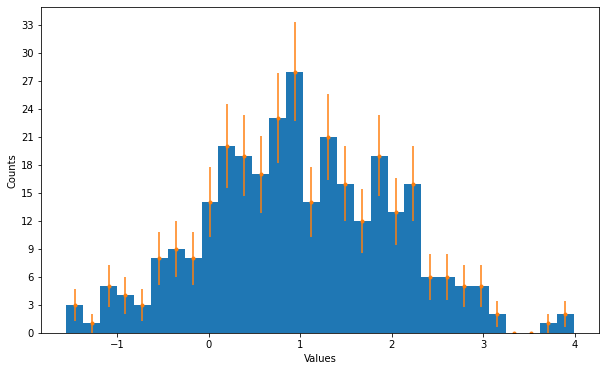

In [2]:
#Creating the figure
fig, ax = plt.subplots(figsize=(10, 6))
#Defining sigma and mu for the distribution 
sigma=1
mu=1
#Defining the array with 300 numbers
x=np.asarray(sigma*np.random.randn(300)+mu)
#Plotting the histogram
y, bin_edges, cont=plt.hist(x,30)
#Finding the centers for the bins
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
#Naming the axis names and labels
ax.set_ylabel("Counts")
ax.set_xlabel("Values")
ax.set_yticks([3*i for i in range(14)])
#Adding errorbars to the histogram
plt.errorbar(
    bin_centers,
    y,
    yerr = y**0.5,
    marker = '.',
    drawstyle = 'steps-mid',
    linestyle='None'
)

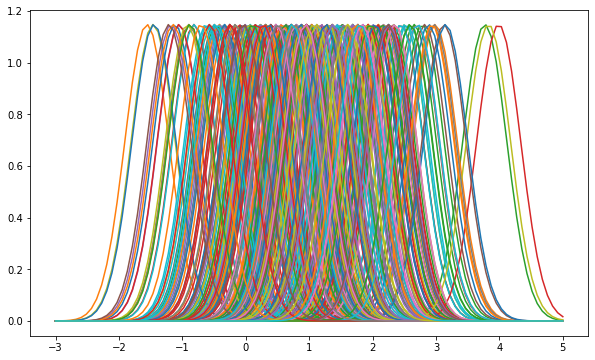

In [3]:
#Calculating std
std=1.06*x.std()*x.size**(-1/5)
#Defining a standard linespace for gaussian plot
l = np.linspace(-3,5, 100)
#Defining the gaussians array
gauss=np.asarray([sc.stats.norm(i,std).pdf(l) for i in x])
#Creating the figure and plotting the gaussians
fig, ax = plt.subplots(figsize=(10, 6))
for j in gauss:
    ax.plot(l, j)

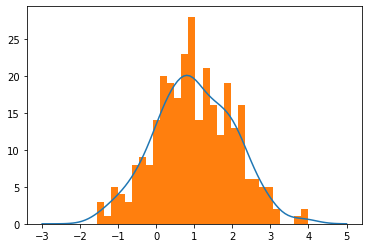

In [8]:
#Summing the values for each point 
sgauss=gauss.sum(axis=0)
#Finding the normalization costant
norm=sc.integrate.trapz(sgauss,x=l)
#Redefining the plot using a normalized array
sgauss=sgauss*sc.integrate.trapz(y,x=bin_centers)/norm
#Plot
plt.plot(l,sgauss)
y, bin_edges, cont=plt.hist(x,30)


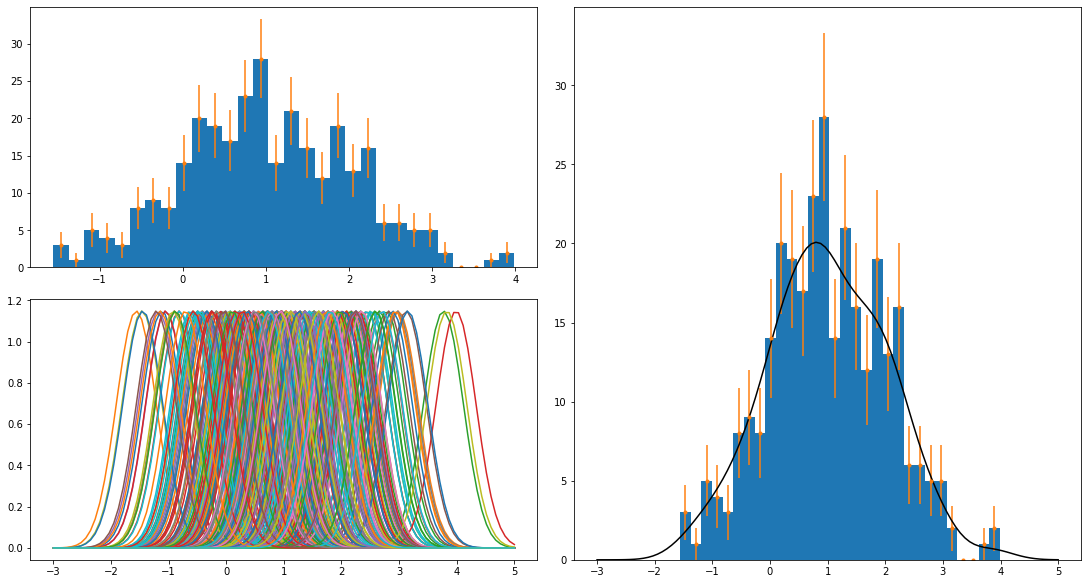

In [11]:
#Final plots
fig = plt.figure(constrained_layout=True,figsize=(15, 8))
gs=fig.add_gridspec(2,2)
f_ax1=fig.add_subplot(gs[0,0])
f_ax2=fig.add_subplot(gs[1,0])
f_ax3=fig.add_subplot(gs[:,1])
f_ax1.hist(x,30)
f_ax1.errorbar(
    bin_centers,
    y,
    yerr = y**0.5,
    marker = '.',
    drawstyle = 'steps-mid',
    linestyle='None'
)
for j in gauss:
    f_ax2.plot(l, j)
f_ax3.hist(x,30)
f_ax3.errorbar(
    bin_centers,
    y,
    yerr = y**0.5,
    marker = '.',
    drawstyle = 'steps-mid',
    linestyle='None'
)
f_ax3.plot(l,sgauss, color='k')

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

--2020-11-17 15:24:07--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [following]
--2020-11-17 15:24:07--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf16eb16b483eb7e74ced894a17.dl.dropboxusercontent.com/cd/0/inline/BDUBxXmU3nczHEMpCUPPw266kZWZA_kusMaJGnU6FZQmpg2DeplD3bU3vlcGQNbzfEN-XhYY8fhAgchucXiEAmQ9Z2xOw1aDPDmynEwt8EZTkQ/file# [following]
--2020-11-17 15:24:08--  https://ucf16eb16b483eb7e74ced894a17.dl.dropboxusercontent.com/cd/0/inline/BDUBxXmU3nczHEMp

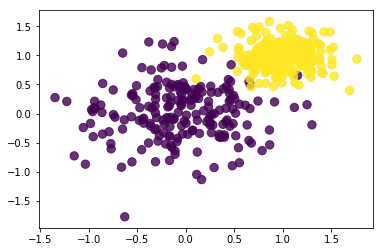

In [62]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

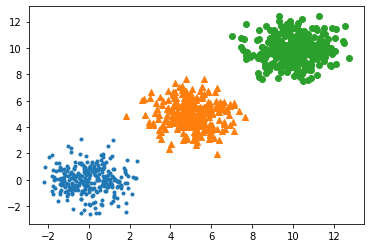

In [15]:
#Defining a general function to generate a series of 2D gaussians
def datasets(mean,std,cat):
    sets=pd.DataFrame(columns=["x","y","category"])
    for i,j,z in zip(mean,std,cat):
        x=j*np.random.randn(300,2)+i
        sets=pd.concat([sets,pd.DataFrame(list(zip(x[:,0],x[:,1],[z]*len(x))),columns=["x","y","category"])])
    return sets
#Defining three different categories, markers, means and std
cat=["cat1","cat2","cat3"]
markers=[".","^","o"]
data=datasets([0,5,10],[1,1,1],cat)
#Final plot
for name,mark in zip(cat,markers):
    dplot=data[data["category"]==name]
    plt.scatter(dplot["x"],dplot["y"],marker=mark)

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [17]:
!wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

--2020-11-24 20:34:16--  https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hgnvyj9abatk8g6/residuals_261.npy [following]
--2020-11-24 20:34:16--  https://www.dropbox.com/s/raw/hgnvyj9abatk8g6/residuals_261.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf7d3884cc5d0094e26d913af90.dl.dropboxusercontent.com/cd/0/inline/BD0aata2WvZC1hDbtUkfHKXCfFJ5uRH-BgWelJTaTg7J0X0qGAh1UR0khdg0YhiNgsq621ZaQMAAxacejKk4XeDNnD82jh2PsXLhuX1CyWTayg/file# [following]
--2020-11-24 20:34:17--  https://ucf7d3884cc5d0094e26d913af90.dl.dropboxusercontent.com/cd/0/inline/BD0aata2WvZC1hDbtUkfHKXCfFJ5uRH-BgWelJTaTg7J0X0qGAh1UR0khd

<ipython-input-19-4fe511d0c19e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df[df["residuals"]<2][df["residuals"]>-2]
/home/filippo/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Regression parameters: 0.0032597701220305835 -0.15432816763069473 0.04340351052255908 8.717037183576464e-06 0.0007327014008445791


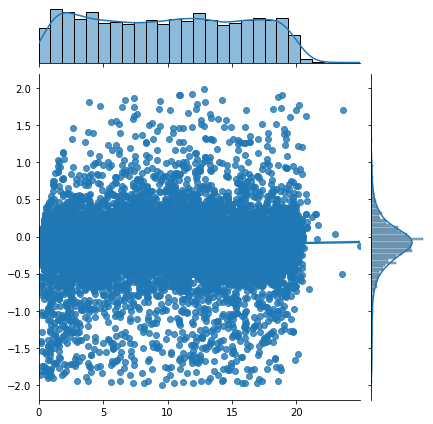

In [19]:
#Loading np file into an array
arr=np.load("residuals_261.npy",allow_pickle=True)
df=pd.DataFrame(arr.item())
#Cleaning the sample
df=df[df["residuals"]<2][df["residuals"]>-2]
#Performing the regression of residuals versus distance using scipy
residuals=np.asarray(df.residuals)
distances=np.asarray(df.distances)
slope, intercept, r_value, p_value, std_err=sc.stats.linregress(distances,residuals)
print("Regression parameters:",slope, intercept, r_value, p_value, std_err)
#Plotting a jointplot with linear regression
sns.jointplot(distances,residuals, kind="reg")

In [20]:
#Defining the x array with the central bins
x=[x*0.5 for x in range(1,40) ]
#Defining the y array 
y=[]
erry=[]
#Filling the arrays with the medium and std values for the residual values
for i in x:
    if i==0.5:
        y.append(np.asarray(df[df["distances"]<i]["residuals"]).mean())
        erry.append(np.asarray(df[df["distances"]<i]["residuals"]).std())
    else:
        dfok=df[df["distances"]<i]
        dfok=dfok[dfok["distances"]>i-0.5]
        y.append(np.asarray(dfok["residuals"]).mean())
        erry.append(np.asarray(dfok["residuals"]).std())

/home/filippo/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<ErrorbarContainer object of 3 artists>

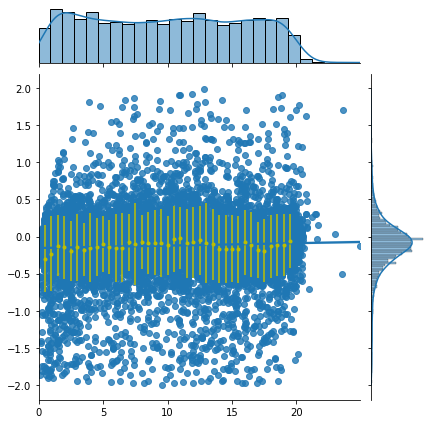

In [22]:
#Plotting the profile plot
sns.jointplot(distances,residuals, kind="reg")
plt.errorbar(x,y,yerr=erry,color='y',
    linestyle='None', marker='.')